In [0]:
from torch.nn import *
from torch.utils.data import TensorDataset,DataLoader
from torch.nn.functional import logsigmoid
from torch import load, sigmoid, cat, rand, bmm, mean, matmul
from torch.optim import Adam
import torch

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
config = {
    'visfeat' : '/content/drive/My Drive/Group_9/src/data/train/feat/visualfeatures',
    'textfeat': '/content/drive/My Drive/Group_9/src/data/train/feat/textfeatures',
    'textembedmat' : '/content/drive/My Drive/Group_9/src/data/train/feat/smallnwjc2vec',
    'traindata' : '/content/drive/My Drive/Group_9/src/data/train/data/train.csv',
    'testdata' : '/content/drive/My Drive/Group_9/src/data/train/data/test.csv',
}

In [0]:
class BPR(Module):

  def __init__(self, userset:iter, itemset:iter, hidden_dim = 512):
    super(BPR, self).__init__()

    self.hidden_dim = hidden_dim

    self.user_alpha = Embedding(len(userset), self.hidden_dim)
    self.item_alpha = Embedding(len(itemset), self.hidden_dim)
    self.user_beta = Embedding(len(userset), 1)
    self.item_beta = Embedding(len(itemset), 1)

    init.uniform_(self.user_alpha.weight, 0, 0.01)
    init.uniform_(self.user_beta.weight, 0, 0.01)
    init.uniform_(self.item_alpha.weight, 0, 0.01)
    init.uniform_(self.item_beta.weight, 0, 0.01)

    self.user_set = list(userset)
    self.item_set = list(itemset)

    self.user_idx = {user : ind for ind, user in enumerate(userset)}
    self.item_idx = {item : ind for ind , item in enumerate(itemset)}

  def get_user_idx(self, users):
    return torch.tensor([self.user_idx[user] for user in users]).long().to(device)

  def get_item_idx(self, items):
    return torch.tensor([self.item_idx[item] for item in items]).long().to(device)
  

  def forward(self, users, items):

    batchsize = len(users)
    user_alpha = self.user_alpha(self.get_user_idx(users))
    user_beta = self.user_beta(self.get_user_idx(users))
    item_alpha = self.item_alpha(self.get_item_idx(items))
    item_beta = self.item_beta(self.get_item_idx(items))

    out = user_beta.view(batchsize) + item_beta.view(batchsize) \
          + bmm(user_alpha.view(batchsize,1,self.hidden_dim),
                item_alpha.view(batchsize,self.hidden_dim,1)).view(batchsize)

    return out
  
  def fit(self, users, items):

    batchsize = len(users)
    user_alpha = self.user_alpha(self.get_user_idx(users))
    user_beta = self.user_beta(self.get_user_idx(users))
    item_alpha = self.item_alpha(self.get_item_idx(items))
    item_beta = self.item_beta(self.get_item_idx(items))

    out = user_beta.view(batchsize) + item_beta.view(batchsize) \
          + bmm(user_alpha.view(batchsize,1,self.hidden_dim),
                item_alpha.view(batchsize,self.hidden_dim,1)).view(batchsize)

    outweight = user_alpha.norm(p=2) + user_beta.norm(p=2) + item_alpha.norm(p=2) + item_beta.norm(p=2)

    return out, outweight

In [0]:
class VTBPR(BPR):

  def __init__(self, userset, itemset, hidden_dim=512):
    super(VTBPR, self).__init__(userset, itemset, hidden_dim=hidden_dim)

    self.user_visembed = Embedding(len(userset), self.hidden_dim)
    self.user_textembed = Embedding(len(userset), self.hidden_dim)

    init.uniform_(self.user_visembed.weight, 0, 0.01)
    init.uniform_(self.user_textembed.weight, 0, 0.01)

  def forward(self, users, items, visfeat, textfeat):
    batchsize = len(users)
    bpr = BPR.forward(self, users, items)
    theta_user_vis = self.user_visembed(self.get_user_idx(users))
    theta_user_text = self.user_textembed(self.get_user_idx(users))

    out1 = bmm(theta_user_vis.view(batchsize,1,self.hidden_dim),
               visfeat.view(batchsize,self.hidden_dim,1)).view(batchsize)
    out2 = bmm(theta_user_text.view(batchsize,1,self.hidden_dim),
               textfeat.view(batchsize,self.hidden_dim,1)).view(batchsize)

    return bpr + out1 + out2
  
  def fit(self, users, items, visfeat, textfeat):
    batchsize = len(users)
    bpr, bprweight = BPR.fit(self, users, items)
    theta_user_vis = self.user_visembed(self.get_user_idx(users))
    theta_user_text = self.user_textembed(self.get_user_idx(users))

    out1 = bmm(theta_user_vis.view(batchsize,1,self.hidden_dim),
               visfeat.view(batchsize,self.hidden_dim,1)).view(batchsize)
    out2 = bmm(theta_user_text.view(batchsize,1,self.hidden_dim),
               textfeat.view(batchsize,self.hidden_dim,1)).view(batchsize)
    
    outweight = bprweight + self.user_visembed(self.get_user_idx(set(users))).norm(p=2) \
                          + self.user_textembed(self.get_user_idx(set(users))).norm(p=2)

    return bpr + out1 + out2 , outweight

In [0]:
class TextCNN(Module):
  def __init__(self, sent_size = (83,300), output_size = 512):
    super(TextCNN,self).__init__()
    self.max_length , self.wordvec_size = sent_size

    self.textcnn = ModuleList([Sequential(
        Conv2d(in_channels=1,out_channels=100,kernel_size=(2,self.wordvec_size),stride=1),
        Sigmoid(),
        MaxPool2d(kernel_size=(self.max_length-1,1),stride=1)),
        Sequential(
        Conv2d(in_channels=1,out_channels=100,kernel_size=(3,self.wordvec_size),stride=1),
        Sigmoid(),
        MaxPool2d(kernel_size=(self.max_length-2,1),stride=1)),
        Sequential(
        Conv2d(in_channels=1,out_channels=100,kernel_size=(4,self.wordvec_size),stride=1),
        Sigmoid(),
        MaxPool2d(kernel_size=(self.max_length-3,1),stride=1)),
        Sequential(
        Conv2d(in_channels=1,out_channels=100,kernel_size=(5,self.wordvec_size),stride=1),
        Sigmoid(),
        MaxPool2d(kernel_size=(self.max_length-4,1),stride=1))
        ])
    
    self.textnn = Sequential(
        Linear(in_features=400,out_features=output_size),
        Sigmoid()
    )

  def forward(self, input):

    conv = cat([conv2d(input).squeeze_(-1).squeeze_(-1) for conv2d in self.textcnn], 1)
    output = self.textnn(conv)
    return output

In [0]:
class PAIBPR(Module):

  def __init__(self, userset, itemset, embedding_weight, maxsentlen = 83, textfeat_dim = 300, visfeat_dim = 2048, hidden_dim = 512, uniform = 0.5):
    super(PAIBPR, self).__init__()

    self.uniform = uniform
    self.hidden_dim = hidden_dim
    self.maxsentlen = maxsentlen
    self.epoch = 0

    self.visencoder = Sequential(
        Linear(in_features=visfeat_dim,out_features=hidden_dim),
        Sigmoid()
    )

    self.visencoder[0].apply(lambda module: init.uniform_(module.weight.data,0,0.001))
    self.visencoder[0].apply(lambda module: init.uniform_(module.bias.data,0,0.001))

    self.text_embedding = Embedding.from_pretrained(embedding_weight, freeze=False)

    self.vtbpr = VTBPR(userset=userset, itemset=itemset, hidden_dim= self.hidden_dim)
    self.textcnn = TextCNN(sent_size=(self.maxsentlen,textfeat_dim), output_size=self.hidden_dim)

  def forward(self, batch, visfeat, textfeat):

    Us = [str(int(pair[0])) for pair in batch]
    Is = [str(int(pair[1])) for pair in batch]
    Js = [str(int(pair[2])) for pair in batch]
    Ks = [str(int(pair[3])) for pair in batch]

    with torch.cuda.device(torch.cuda.current_device()):
      stream1 = torch.cuda.Stream()
      stream2 = torch.cuda.Stream()

      Ivis = self.visencoder(cat([visfeat[I].unsqueeze(0) for I in Is], 0).to(device))
      with torch.cuda.stream(stream1):
        Jvis = self.visencoder(cat([visfeat[J].unsqueeze(0) for J in Js], 0).to(device))
      with torch.cuda.stream(stream2):
        Kvis = self.visencoder(cat([visfeat[K].unsqueeze(0) for K in Ks], 0).to(device))

      Itext = self.textcnn(self.text_embedding(cat([textfeat[I].unsqueeze(0) for I in Is], 0).to(device)).unsqueeze_(1))
      with torch.cuda.stream(stream1):
        Jtext = self.textcnn(self.text_embedding(cat([textfeat[J].unsqueeze(0) for J in Js], 0).to(device)).unsqueeze_(1))
      with torch.cuda.stream(stream2):
        Ktext = self.textcnn(self.text_embedding(cat([textfeat[K].unsqueeze(0) for K in Ks], 0).to(device)).unsqueeze_(1))
      
    torch.cuda.synchronize()

    stream1 = torch.cuda.Stream()
    stream2 = torch.cuda.Stream()

    vis_ij = bmm(Ivis.unsqueeze(1), Jvis.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
    with torch.cuda.stream(stream1):
      text_ij = bmm(Itext.unsqueeze(1), Jtext.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
      cuj = self.vtbpr(Us, Js, Jvis, Jtext)
    
    vis_ik = bmm(Ivis.unsqueeze(1), Kvis.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
    with torch.cuda.stream(stream2):
      text_ik = bmm(Itext.unsqueeze(1), Ktext.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
      cuk = self.vtbpr(Us, Ks, Kvis, Ktext)

    torch.cuda.synchronize()

    p_ij = 0.5 * vis_ij + 0.5 * text_ij
    p_ik = 0.5 * vis_ik + 0.5 * text_ik

    return self.uniform * p_ij + (1 - self.uniform) * cuj - ( self.uniform * p_ik + (1 - self.uniform) * cuk )


  def fit(self, batch, visfeat, textfeat):

    Us = [str(int(pair[0])) for pair in batch]
    Is = [str(int(pair[1])) for pair in batch]
    Js = [str(int(pair[2])) for pair in batch]
    Ks = [str(int(pair[3])) for pair in batch]

    with torch.cuda.device(torch.cuda.current_device()):
      stream1 = torch.cuda.Stream()
      stream2 = torch.cuda.Stream()

      Ivis = self.visencoder(cat([visfeat[I].unsqueeze(0) for I in Is], 0).to(device))
      with torch.cuda.stream(stream1):
        Jvis = self.visencoder(cat([visfeat[J].unsqueeze(0) for J in Js], 0).to(device))
      with torch.cuda.stream(stream2):
        Kvis = self.visencoder(cat([visfeat[K].unsqueeze(0) for K in Ks], 0).to(device))

      Itext = self.textcnn(self.text_embedding(cat([textfeat[I].unsqueeze(0) for I in Is], 0).to(device)).unsqueeze_(1))
      with torch.cuda.stream(stream1):
        Jtext = self.textcnn(self.text_embedding(cat([textfeat[J].unsqueeze(0) for J in Js], 0).to(device)).unsqueeze_(1))
      with torch.cuda.stream(stream2):
        Ktext = self.textcnn(self.text_embedding(cat([textfeat[K].unsqueeze(0) for K in Ks], 0).to(device)).unsqueeze_(1))
      
    torch.cuda.synchronize()

    stream1 = torch.cuda.Stream()
    stream2 = torch.cuda.Stream()

    vis_ij = bmm(Ivis.unsqueeze(1), Jvis.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
    with torch.cuda.stream(stream1):
      text_ij = bmm(Itext.unsqueeze(1), Jtext.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
      cuj, cujweight = self.vtbpr.fit(Us, Js, Jvis, Jtext)
    
    vis_ik = bmm(Ivis.unsqueeze(1), Kvis.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
    with torch.cuda.stream(stream2):
      text_ik = bmm(Itext.unsqueeze(1), Ktext.unsqueeze(-1)).squeeze_(-1).squeeze_(-1)
      cuk, cukweight = self.vtbpr.fit(Us, Ks, Kvis, Ktext)

    torch.cuda.synchronize()

    p_ij = 0.5 * vis_ij + 0.5 * text_ij
    p_ik = 0.5 * vis_ik + 0.5 * text_ik

    output = self.uniform * p_ij + (1 - self.uniform) * cuj - ( self.uniform * p_ik + (1 - self.uniform) * cuk )

    cujkweight = self.vtbpr.user_alpha(self.vtbpr.get_user_idx(set(Us))).norm(p=2) + self.vtbpr.item_alpha(self.vtbpr.get_item_idx(set(Js+Ks))).norm(p=2) \
              + self.vtbpr.user_visembed(self.vtbpr.get_user_idx(set(Us))).norm(p=2) + self.vtbpr.user_textembed(self.vtbpr.get_user_idx(set(Us))).norm(p=2)
    
    outweight = cujkweight + self.text_embedding(cat([textfeat[I].unsqueeze(0) for I in set(Is+Js+Ks)], 0).cuda()).norm(p=2)

    return  output, outweight


In [0]:
def load_csv_data(train_data_path):
    result = []
    with open(train_data_path,'r') as fp:
        for line in fp:
            t = line.strip().split(',')
            t = [int(i) for i in t]
            result.append(t)
    return result

In [0]:
def load_embedding_weight(device):
    jap2vec = torch.load(config['textembedmat'])
    embeding_weight = []
    for jap, vec in jap2vec.items():
        embeding_weight.append(vec.tolist())
    embeding_weight.append(torch.zeros(300))
    embedding_weight = torch.tensor(embeding_weight, device=device)
    return embedding_weight

In [0]:
def train(model, traindata, visfeat, textfeat, optim):

  model.train()
  trainloss = 0
  for i, batch in enumerate(traindata):
    output, outputweight = model.fit(batch[0], visfeat, textfeat)
    loss = (-logsigmoid(output)).sum() + 0.001*outputweight
    trainloss += loss
    optim.zero_grad()
    loss.backward()
    optim.step()
  print('Training Loss : ', trainloss.item()/len(traindata))

In [0]:
def evaluate(model, test_csv, visfeat, textfeat):

  model.eval()
  testdata = load_csv_data(test_csv)
  pos = 0
  batchs = 100
  for i in range(0, len(testdata), batchs):
    data = testdata[i:i+batchs] if i+batchs <=len(testdata) else testdata[i:]
    output = model.forward(data, visfeat, textfeat)  
    pos += float(torch.sum(output.ge(0)))
  auc = pos/len(testdata)
  print( "Testing....    Epoch : ", model.epoch,' AUC: ', auc )
  return auc


In [0]:
hidden_dim=512
batch_size=256
uniform = 0.05
epochs=60
print('loading top&bottom features')
train_data = load_csv_data(config['traindata'])
visfeat = torch.load(config['visfeat'],map_location= lambda storage, loc: storage.cuda())
textfeat = torch.load(config['textfeat'],map_location=lambda storage, loc: storage.cuda())


embedding_weight = load_embedding_weight(torch.cuda.current_device())
item_set= set()
user_set = set([str(i[0]) for i in train_data])
for i in train_data:
  item_set.add(str(int(i[2])))
  item_set.add(str(int(i[3])))

loading top&bottom features


In [0]:
model = PAIBPR(userset = user_set, itemset = item_set, embedding_weight=embedding_weight, uniform = uniform).to(torch.cuda.current_device())

optim = Adam([
    {
        'params' : model.parameters(),
        'lr' : 0.001,
        'weight_decay' : 0.00012  #0.0002 #
    }
    ])
  
train_data = TensorDataset(torch.tensor(train_data, dtype=torch.int))
train_loader = DataLoader(train_data, batch_size= batch_size,shuffle=True, drop_last=True)

In [0]:
aucs = []     # for plot
for i in range(epochs): 
  train(model, train_loader, visfeat, textfeat, optim)
  model.epoch+=1
  testauc = evaluate(model, config['testdata'], visfeat, textfeat)
  aucs.append(testauc)

Training Loss :  161.5860408399471
Testing....    Epoch :  1  AUC:  0.6941329292054558
Training Loss :  96.83493510251323
Testing....    Epoch :  2  AUC:  0.7656202641264342
Training Loss :  34.05472366898148
Testing....    Epoch :  3  AUC:  0.7857111928988959
Training Loss :  9.99207447193287
Testing....    Epoch :  4  AUC:  0.7935483870967742
Training Loss :  4.886344142691799
Testing....    Epoch :  5  AUC:  0.7992639099372159
Training Loss :  3.4934443721064814
Testing....    Epoch :  6  AUC:  0.8004329941545789
Training Loss :  2.942885948867394
Testing....    Epoch :  7  AUC:  0.8050660316085733
Training Loss :  2.6901978184937168
Testing....    Epoch :  8  AUC:  0.8076639965360468
Training Loss :  2.5802964306382274
Testing....    Epoch :  9  AUC:  0.811560943927257
Training Loss :  2.7393240146536044
Testing....    Epoch :  10  AUC:  0.8155011907339251
Training Loss :  2.552433558872768
Testing....    Epoch :  11  AUC:  0.8123836328209569
Training Loss :  2.5702232078269676
Tes

KeyboardInterrupt: ignored

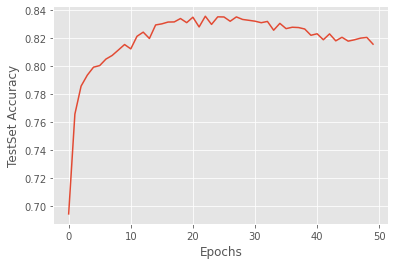

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.xlabel('Epochs')
plt.ylabel('TestSet Accuracy')
plt.plot(aucs)